# **Statistics(I)(2) - Final Project Code**
## **Task 3**

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats
import seaborn as sns
import math

In [39]:
def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

In [40]:
def chi_square_normality_test(x, bins=8):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    mu, sigma = np.mean(x), np.std(x, ddof=1)

    bin_edges = np.histogram_bin_edges(x, bins=bins)
    observed, _ = np.histogram(x, bins=bin_edges)
    expected_probs = np.diff(stats.norm.cdf(bin_edges, loc=mu, scale=sigma))
    expected = expected_probs * n

    # Merge bins with expected < 5 (left to right)
    obs, exp, edges = observed.tolist(), expected.tolist(), bin_edges.tolist()
    i = 0
    while i < len(exp) and exp[i] < 5:
        exp[i+1] += exp[i]
        obs[i+1] += obs[i]
        del exp[i], obs[i], edges[i+1]
    i = len(exp) - 1
    while i >= 0 and exp[i] < 5:
        exp[i-1] += exp[i]
        obs[i-1] += obs[i]
        del exp[i], obs[i], edges[i]
        i -= 1

    df = len(exp) - 3  # minus 2 for estimated μ and σ, and 1 for constraint
    chi2_stat = np.sum((np.array(obs) - np.array(exp)) ** 2 / np.array(exp))
    p_value = stats.chi2.sf(chi2_stat, df)

    return {"chi2_stat": chi2_stat, "p_value": p_value, "df": df}

In [41]:
def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

In [42]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

In [43]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

filtered_df['source_category'] = (
    filtered_df['source'].apply(
        lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted'
    )
)

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.pow(filtered_df["production_budget"], 1/8)
filtered_df["flattened_total_box_office"] = np.pow(filtered_df["total_box_office"], 1/8)

filtered_df['z_score'] = stats.zscore(filtered_df['flattened_total_box_office'])
filtered_df = filtered_df[filtered_df['z_score'].abs() <= 3].copy()

filtered_df['budget_category'] = pd.cut(
    filtered_df['production_budget'], 
    bins=[0, 15000000, np.inf], 
    labels=['Low', 'High']
)

budget_low = filtered_df[filtered_df['budget_category'] == 'Low']['flattened_total_box_office']
budget_high = filtered_df[filtered_df['budget_category'] == 'High']['flattened_total_box_office']

In [44]:
combined_df = pd.concat([
        filtered_df[filtered_df['source_category'] == 'Original Screenplay'], 
        filtered_df[filtered_df['source_category'] == 'Adapted']
    ]
)

target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
combined_df = combined_df[combined_df['genre'].isin(target_genres)]
combined_df['group_label'] = (
    combined_df['source_category'].astype(str)
    + ' - '
    + combined_df['genre'].astype(str)
)

shapiro_results = shapiro_wilk_test(combined_df, 'flattened_total_box_office', 'group_label')

Shapiro-Wilk Test for Normality (alpha = 0.05):

For factor = Original Screenplay - Comedy
  Shapiro statistic = 0.947043, p-value = 0.000000 → Not Normal
For factor = Original Screenplay - Thriller/Suspense
  Shapiro statistic = 0.954564, p-value = 0.000000 → Not Normal
For factor = Original Screenplay - Romantic Comedy
  Shapiro statistic = 0.927385, p-value = 0.000002 → Not Normal
For factor = Original Screenplay - Drama
  Shapiro statistic = 0.986710, p-value = 0.000418 → Not Normal
For factor = Adapted - Drama
  Shapiro statistic = 0.990776, p-value = 0.000814 → Not Normal
For factor = Adapted - Romantic Comedy
  Shapiro statistic = 0.916080, p-value = 0.005124 → Not Normal
For factor = Adapted - Thriller/Suspense
  Shapiro statistic = 0.978049, p-value = 0.020564 → Not Normal
For factor = Adapted - Comedy
  Shapiro statistic = 0.938531, p-value = 0.000002 → Not Normal


In [45]:
grouped = combined_df.groupby('group_label')['flattened_total_box_office']

chi2_results = {}
for group_name, values in grouped:
    try:
        result = chi_square_normality_test(values, bins=6)
        chi2_results[group_name] = result
    except Exception as e:
        chi2_results[group_name] = {"error": str(e)}

for group, result in chi2_results.items():
    if 'error' in result:
        print(f"{group}: ERROR - {result['error']}")
    else:
        print(f"{group}: chi2 = {result['chi2_stat']:.2f}, p = {result['p_value']:.4f}, df = {result['df']}")

Adapted - Comedy: chi2 = 17.02, p = 0.0002, df = 2
Adapted - Drama: chi2 = 10.16, p = 0.0173, df = 3
Adapted - Romantic Comedy: chi2 = 1.81, p = 0.1787, df = 1
Adapted - Thriller/Suspense: chi2 = 7.08, p = 0.0290, df = 2
Original Screenplay - Comedy: chi2 = 79.47, p = 0.0000, df = 3
Original Screenplay - Drama: chi2 = 16.08, p = 0.0011, df = 3
Original Screenplay - Romantic Comedy: chi2 = 15.67, p = 0.0004, df = 2
Original Screenplay - Thriller/Suspense: chi2 = 41.51, p = 0.0000, df = 3


In [46]:
bartlett_result = bartlett_test(
    df=combined_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05
)

Bartlett’s Test for Equal Variances:
  Test statistic = 15.386462, p-value = 0.031353 → Variances differ significantly


In [47]:
combined_df['genre'] = combined_df['genre'].astype('category')
combined_df['source_category'] = combined_df['source_category'].astype('category')

model = smf.ols(
    'flattened_total_box_office ~ C(genre) + C(source_category) + C(genre):C(source_category)',
    data=combined_df
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                  sum_sq      df          F        PR(>F)
C(genre)                      479.918166     3.0  38.017839  5.703950e-24
C(source_category)            400.354402     1.0  95.145028  4.737578e-22
C(genre):C(source_category)    65.130901     3.0   5.159497  1.483986e-03
Residual                     9606.483013  2283.0        NaN           NaN


Q critical value = 4.290278
Tukey Omega = 0.727431
                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
                group1                                 group2                 meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------
                     Adapted - Comedy                         Adapted - Drama  -0.2896 0.7628 -0.8459  0.2667  False
                     Adapted - Comedy               Adapted - Romantic Comedy   0.7606  0.405 -0.3301  1.8513  False
                     Adapted - Comedy             Adapted - Thriller/Suspense    0.591 0.1954 -0.1259   1.308  False
                     Adapted - Comedy            Original Screenplay - Comedy  -0.2753 0.8244  -0.844  0.2935  False
                     Adapted - Comedy             Original Screenplay - Drama  -1.4547    0.0 -2.0307 -0.8788   True
             

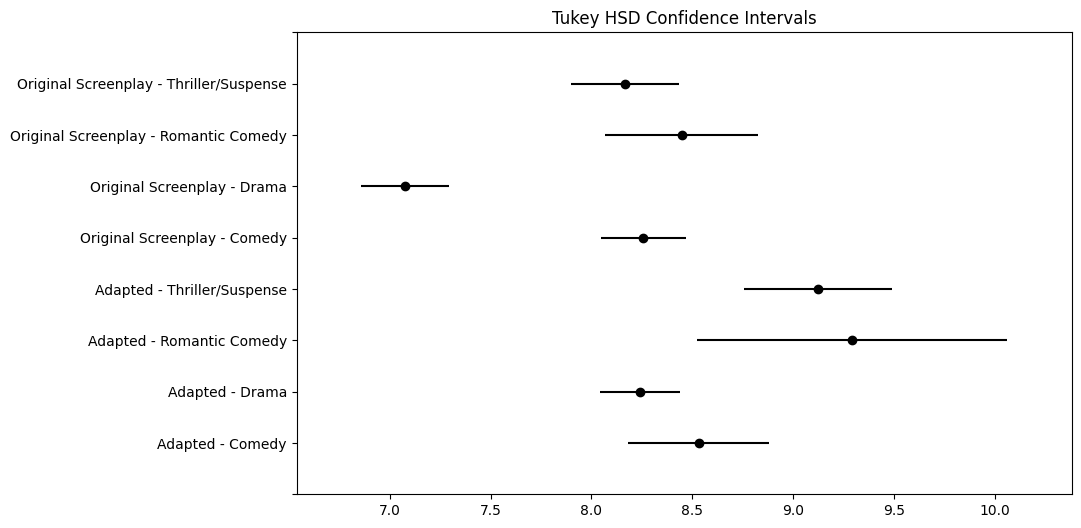

In [48]:
summary, omega = tukey_hsd(
    df=combined_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05,
    comparison_focus=None
)